# Интеллектуальный агент анализа транзакций (ML + LLM)

## 1. Цель работы

Настоящая тетрадка реализует слой инференса и интерпретации гибридной системы анализа транзакционных рисков.  
Основная цель — объединить количественные предсказания модели машинного обучения с возможностями крупной языковой модели (LLM) для получения как числовых оценок риска, так и человекопонятных объяснений.

На данном этапе используется **синтетический набор данных**, созданный тем же скриптом, что и в первой тетрадке, для проверки корректности логики и устойчивости системы.

---

## 2. Задачи

1. Загрузить сохранённую ML-модель и кодировщик меток.  
2. Сгенерировать признаки из входных данных в формате, идентичном этапу обучения.  
3. Рассчитать вероятностные оценки риска и классы по ML-модели.  
4. Вычислить дополнительные показатели:
   - признаки коротких транзитных цепочек (≤ 24 ч);  
   - аномалии по сумме (z-score) и частоте операций.  
5. Реализовать взаимодействие с LLM (GigaChat):
   - формирование структурированного системного промпта;  
   - получение ответа в формате JSON.  
6. Реализовать проверку и обработку ошибок (валидация JSON, fallback-логика при сбое LLM).  
7. Сформировать итоговый отчёт (Excel / Parquet) с подсветкой уровней риска и краткими пояснениями.

---

## 3. План выполнения работ

| Этап | Содержание | Результат |
|------|-------------|------------|
| Инициализация | Загрузка конфигурации, артефактов и окружения | Проверка готовности |
| Генерация признаков | Преобразование данных в формат модели | Единообразная матрица признаков |
| Скоринг ML-модели | Расчёт вероятностей и классов | Количественные оценки риска |
| Обнаружение аномалий | Анализ транзитных и статистических отклонений | Дополнительные индикаторы |
| Взаимодействие с LLM | Отправка промпта и получение объяснения | Текстовые интерпретации |
| Постобработка | Проверка структуры ответа, fallback при ошибке | Гарантированный результат |
| Формирование отчёта | Экспорт результатов в Excel/Parquet | Итоговые аналитические файлы |

---

## 4. Методологическое обоснование

Модель машинного обучения обеспечивает количественную оценку риска на основании признаков транзакции.  
Однако числовой результат не даёт понимания причин классификации.  
Языковая модель выполняет функцию интерпретационного слоя, который:
- переводит численные результаты ML в понятные формулировки;  
- выявляет наиболее вероятные причины высокого риска (назначение, транзит, аномальная сумма и т. д.);  
- формирует итоговое описание в структурированном виде.

Такое объединение позволяет совместить **статистическую точность** ML-модели с **семантической прозрачностью** LLM, что повышает интерпретируемость и прикладную ценность результатов анализа.

---

## 5. Ожидаемый результат

Функционирующий агент, который:
- принимает входные данные с транзакциями;  
- выполняет скоринг ML-модели;  
- получает пояснения и рекомендации через LLM;  
- сохраняет структурированные и визуально понятные отчёты;  
- обеспечивает устойчивую работу даже при недоступности LLM.

Агент образует прикладной уровень системы — интерфейс для аналитиков, предоставляющий одновременно численные и текстовые интерпретации риска.


### Инициализация агента: загрузка артефактов, глобальное состояние, лексиконы, утилиты и LLM-клиент

**Цель секции:**  
Подготовить окружение инференса: найти и загрузить сохранённые артефакты из обучающей тетрадки (Pipeline и LabelEncoder), определить глобальное состояние выполнения, зафиксировать лексиконы для текстовых признаков, объявить вспомогательные функции для предобработки, задать системный промпт и инициализировать клиент LLM.

---

**Задачи секции:**
1. **Поиск и загрузка артефактов**  
   - Найти сохранённые пайплайны `best_pipeline_*.joblib` (или резервный `pipeline_hgb.joblib`).  
   - Загрузить ML-пайплайн (`pipe`) и кодировщик меток (`le`) для согласованного инференса.  
   - Провести минимальные проверки наличия артефактов.

2. **Определение глобального состояния**  
   - Создать словарь `STATE` для хранения «сквозных» объектов: сырой/подготовленный DataFrame, артефакты модели, входные данные для LLM и её ответ.

3. **Лексиконы признаков риска**  
   - Задать списки ключевых слов `HIGH_RISK_WORDS` / `MEDIUM_RISK_WORDS` для лексических индикаторов риска в назначении платежа.

4. **Вспомогательные функции предобработки**  
   - `extract_type(name)` — типизация контрагента по префиксу (ЮЛ/ИП/ФЛ/Прочее).  
   - `is_round_amount(x)` — бинарный индикатор «круглой» суммы.  
   - `has_any(text, words)` — проверка наличия ключевых слов.  
   - `purpose_group_fn(text)` — категоризация назначения (`high_kw` / `med_kw` / `low_kw`).

5. **Системный промпт для LLM**  
   - `PROMPT_V3` — строка-шаблон с инструкциями и ожидаемой JSON-структурой (пока пустой; требуется заполнить).

6. **Инициализация LLM-клиента**  
   - Создать клиент `GigaChat` с параметрами генерации (температура, топ-p, таймаут).


In [171]:
# !pip install -U langchain langchain-core langchain-gigachat gigachat python-dotenv xlsxwriter joblib numpy pandas seaborn matplotlib

import os, json, glob, warnings, random
from typing import Any, Dict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_gigachat import GigaChat

warnings.filterwarnings("ignore")
np.random.seed(42); random.seed(42)
sns.set_theme(style="whitegrid", context="talk")
load_dotenv()


True

In [172]:
# Подключаем LLM
import base64
import requests

url = "https://ngw.devices.sberbank.ru:9443/api/v2/oauth"

payload={
  'scope': 'GIGACHAT_API_PERS'
}
headers = {
  'Content-Type': 'application/x-www-form-urlencoded',
  'Accept': 'application/json',
  'RqUID': '2aba969c-a22a-4816-a652-393a756a96c1',
  'Authorization': f'Basic {os.environ.get("GIGACHAT_API_KEY")}',
}

response = requests.request("POST", url, headers=headers, data=payload, verify=False)

print(response.text)

{"access_token":"eyJjdHkiOiJqd3QiLCJlbmMiOiJBMjU2Q0JDLUhTNTEyIiwiYWxnIjoiUlNBLU9BRVAtMjU2In0.FEOZhX9BxOaktZ2Y4ebH93XlssEG2iBDFhn2Tg4TDXcwMPSVk-8tPlccm3unVjYb17qbrdwpBed78B_k6jLywUitjBYtQs0rE6PemXSmknC8qSQ4JAnNB4703ySjid_qXcT8_xsoYGkgKn3ZZa03ZnUvp-UzX8mUum63U80jLFKmH6Vg2D66IbL36cHHgkyonBhPy8Bcwx3AJ5Qo83nXHRyFtRXXYtJabsa9GfAuainyjdlqUjNomQFL8KQGvQ9jKhrTSAMxEU4GHXWxOQoWpSsXhTgblm-WS3035Exq1lgx1ygWi5KnRqyST6NzUIkYy88sfC-HoHg2FLLaVO8Osg.-2QDiOAMeTY6IATfOJf8kw.8FbdJ-Mbb1H-KzwYW5FvNkvRl8WdkfHoLkr3zYoIsxsGLlSnSWGtruuzk4FKNSzeVuecIdiMqRmsg09hO_5QWNKbKns6TY4wGOkQK8cEpMwxFO8SNek9UciZ8B9xaAEzJkeh7eGMAW1wLCqMbVkAIQZgWfYXS9RRNpkYDSCB3AzR-QlUMtwcyayaYxuHdwxMWMFfav7E0Mane7LKT2lQr9iDtAV2b3PNTGjZFJ0o0YZsahHrMrh4KTLfy_NdV5abRcBQCBfhly4HAyeIp_Cu66O_38mSY2SJ7LbEUDlvNupewJW9PBwqQzKRy_kZwJhbwkKLAOzuXDALArm4P7V4wZvR1Mb711JG35_ENSfflYBNsYdMIQAuVuV_hB9fxxuuPu1EqZrXPV27hA5umDn62Xe1g7qJIRWu2GDYa5O3eNlew5gKuxzI6xRrsHg45xPU2Nxsho-iepiEnVnhkBy0lzAvjBKZxAnuCyQMeaiZMll2uMI5qUg4IMKht1WerAA0Nx2RYr3jkTdxnNJNvu7jBdaR2KKmB

In [173]:
data = response.json()
access_token = data['access_token']

In [174]:
# Пути к артефактам из обучающей тетрадки
MODEL_CANDIDATES = sorted(glob.glob("best_pipeline_*.joblib")) or sorted(glob.glob("pipeline_hgb.joblib"))
assert MODEL_CANDIDATES, "Не найден сохранённый Pipeline (*.joblib)."
pipe = joblib.load(MODEL_PATH)
le   = joblib.load(LE_PATH)
assert os.path.exists(LE_PATH), "Нет label_encoder_risk.joblib."

# Глобальное состояние
STATE: Dict[str, Any] = {
    "df_raw": None,
    "df_prep": None,
    "pipe": None,
    "le": None,
    "input_data": None,
    "llm_response": None,
}

# Лексиконы
HIGH_RISK_WORDS = [
    "займ","договор займа","возврат займа","взаиморасчёт","перевод средств","без договора","перевод на карту",
    "личные нужды","крипто","биткоин","usdt","биржа","coin","crypto","swift","иностранный перевод",
    "валютный счёт","экспорт","передача активов","пополнение","наличные","выдача наличных","обналичивание",
    "благотворительность","пожертвование","агентское вознаграждение","комиссионное"
]
MEDIUM_RISK_WORDS = [
    "оплата услуг","услуги по договору","консультационные","маркетинг","премия","бонус","вознаграждение",
    "аванс","предоплата","частичная оплата","аренда","лизинг","субаренда","логистика","транспорт","перевозка","доставка"
]

def extract_type(name: str) -> str:
    if pd.isna(name): return "Прочее"
    s = str(name)
    if s.startswith(("ООО","АО","ОАО","ЗАО")): return "ЮЛ"
    if s.startswith("ИП"): return "ИП"
    if s.startswith("ФЛ"): return "ФЛ"
    return "Прочее"

def is_round_amount(x: float) -> int:
    if pd.isna(x): return 0
    return int((x % 10000 == 0) or (x % 100000 == 0))

def has_any(text: str, words) -> int:
    t = "" if pd.isna(text) else str(text).lower()
    return int(any(w in t for w in words))

def purpose_group_fn(text: str) -> str:
    t = "" if pd.isna(text) else str(text).lower()
    if any(w in t for w in HIGH_RISK_WORDS): return "high_kw"
    if any(w in t for w in MEDIUM_RISK_WORDS): return "med_kw"
    return "low_kw"

# Строгий системный промпт
PROMPT_V3 = r"""
СИСТЕМА
Ты оформляешь результат финмониторинга. Работай ТОЛЬКО по входным данным и правилам. Верни ТОЛЬКО валидный JSON.

ВХОД
INPUT_DATA: [{id:int, purpose:str, ml_metric:float(0..1),
anomaly_amount:float, anomaly_frequency:float, anomaly_purpose:float, anomaly_overall:float,
is_regular_payment:bool, debit_name_type:str, credit_name_type:str,
debit_amount:float|null, credit_amount:float|null, amount:float|null,
debit_inn:str, credit_inn:str, chain_match:str|null, chain_length:int|null, chain_duration_hours:float|null}]

ФЛАГИ
transit_short: (chain_length≥3 и chain_duration_hours<24) или (chain_duration_hours<24 независимо от length)
transit_very_short: chain_duration_hours<0.01
amount_anomaly_strong: anomaly_amount≥0.6
freq_anomaly_strong: anomaly_frequency≥0.6
purpose_anomaly: anomaly_purpose≥0.6
round_large_amount: amount кратна 10 000 или 100 000
purpose_stopword_high: purpose содержит слова высокого риска

ОЦЕНКА
risk_score = max(
  ml_metric,
  0.8*anomaly_overall,
  0.85 если transit_short иначе 0,
  0.15*1[amount_anomaly_strong]+0.15*1[freq_anomaly_strong]+0.15*1[purpose_anomaly]+0.10*1[round_large_amount]+0.25*1[purpose_stopword_high]
). Округли до 0.01 и обрежь в [0,1].
risk_label: ≥0.70 → "красный"; 0.40–0.69 → "желтый"; иначе → "зеленый".

СТИЛЬ ВЫВОДА
Пиши объяснения и рекомендации понятным языком для обычного сотрудника банка или аналитика. 
Избегай сухих машинных формулировок, шаблонов и терминов. Говори коротко, по делу и по-человечески.
Не используй фразу «флаги:», не упоминай технические признаки. 
Тон — нейтральный, деловой, но живой и естественный.

Каждое поле recommendation и risk_explanation обязательно должно быть заполнено. 
Они не могут быть пустыми или содержать служебные фразы вроде «Краткое объяснение сформировано автоматически». 
Если риск низкий, всё равно добавь короткое понятное пояснение и спокойную рекомендацию.

Формат и стиль:
- 1–2 предложения в recommendation;
- 2–3 коротких предложения в risk_explanation;
- без избыточных деталей и дублирования.

Примеры:
  - recommendation: "Проверьте назначение платежа — возможно, не связано с деятельностью компании."
    risk_explanation: "Назначение выглядит нетипично для данного клиента. Возможно, используется не по профилю."
  - recommendation: "Обратите внимание на частые переводы между связанными лицами."
    risk_explanation: "Перевод входит в цепочку быстрых транзакций. Возможна транзитная активность."
  - recommendation: "Уточните обоснование крупной суммы перевода."
    risk_explanation: "Размер платежа превышает обычный диапазон клиента. Требуется документальное подтверждение."

EVIDENCE
Верни: ml_metric, anomaly_amount, amount, chain_match, chain_length, chain_duration_hours.
Разрешено использовать ml_top_reasons (если есть) при формировании объяснения.

ФОРМАТ ОТВЕТА (СТРОГО JSON)
{
  "overall_observation": "<кратко или пусто>",
  "transactions": [
    {
      "id": <int>,
      "purpose": "<str>",
      "risk_label": "красный" | "желтый" | "зеленый",
      "risk_score": <float>,
      "flags": ["..."],
      "primary_reasons": ["...<=5"],
      "evidence": {
        "ml_metric": <float>,
        "anomaly_amount": <float>,
        "amount": <float|null>,
        "chain_match": "<str|null>",
        "chain_length": <int|null>,
        "chain_duration_hours": <float|null>
      },
      "recommendation": "<до 2 предложений>",
      "risk_explanation": "<2–3 коротких предложения>"
    }
  ]
}
Любой иной текст запрещён.
""".strip()


In [175]:
llm = GigaChat(credentials=os.environ.get("GIGACHAT_API_KEY"), model="GigaChat-2", top_p=0, timeout=120, verify_ssl_certs=False, temperature=0.0,)

### Создание инструментов агента (Tools): загрузка данных → признаки/цепочки → локальный ML-скоринг → подготовка LLM → риск-оценка → Excel-отчёт

**Цель секции:**  
Определить набор инструментов (`@tool`) для пошаговой обработки транзакций: от чтения файла и расчёта признаков с транзитными цепочками до локального ML-скоринга, подготовки входа для LLM, вызова LLM с пост-валидацией ответа и формирования итогового Excel-отчёта.

---

**Состав и назначение инструментов:**

1) **`read_data_from_file(file_path, n=None)` — чтение и валидация входных данных**  
   - **Что делает:**  
     - Читает CSV/XLSX (с парсингом даты `date`).  
     - Проверяет наличие обязательных колонок (схема транзакций).  
     - При необходимости берёт случайную подвыборку `n` (фиксированный `random_state=42`) и сортирует по времени.  
     - Гарантирует наличие уникального `id` (если нет — создаёт).  
     - Сохраняет сырой DataFrame в `STATE["df_raw"]`.  
   - **Зачем:** обеспечить корректный и воспроизводимый входной слой, унифицировать схему.  
   - **Вход/Выход:**  
     - Вход: путь к файлу.  
     - Выход: JSON-резюме (`rows`, временной `period`, первые `columns`).  
     - Побочный эффект: заполнен `STATE["df_raw"]`.

2) **`build_chains_and_features()` — построение цепочек и признаков, расчёт аномалий (всегда JSON)**  
   - **Что делает:**  
     - Создает единый признак суммы `amount` (`max(debit_amount, credit_amount)`).  
     - Строит категориальные типы контрагентов (`ЮЛ/ИП/ФЛ/Прочее`), временные фичи (`hour`, `dow`), индикатор «круглости» суммы.  
     - Классифицирует `purpose` на группы (`high_kw`, `med_kw`, `low_kw`) на основе словарей HIGH/MED.  
     - **Формирует краткие транзитные цепочки** ≤ 24ч, длиной ≥3 (и ≤6), с допустимым отклонением по сумме (±2%):  
       помечает операции `chain_id`, `chain_length`, `chain_duration_hours`; выводит агрегат `transit_short` и `transit_like`.  
     - **Рассчитывает аномалии:**  
       - `amount_z_debit` (z-score суммы по `debit_inn`),  
       - `anomaly_amount` (нормированная |z|),  
       - `anomaly_frequency` (суточная частота пар `debit_inn × credit_inn`),  
       - `anomaly_purpose` (прокси через `purpose_stop_high`),  
       - `anomaly_overall` = `max` из трёх аномалий.  
     - Сохраняет результат в `STATE["df_prep"]`.  
   - **Зачем:** получить согласованный с моделью призначный слой и структурные сигналы (цепочки/аномалии) для последующей ML/LLM-оценки.  
   - **Вход/Выход:**  
     - Вход: берёт `STATE["df_raw"]`.  
     - Выход: JSON `{"ok": True, "rows": ..., "chains_found": ...}` либо `{"ok": False, "error": ...}`.  
     - Побочный эффект: заполнен `STATE["df_prep"]`.

3) **`local_model_analysis()` — локальный ML-скоринг (строго фичсет A_base) с проверкой размерностей**  
   - **Что делает:**  
     - Проверяет, что в `df_prep` присутствуют **ровно** признаки A_base:  
       - **NUM:** `amount`, `round_amount`, `hour`, `transit_like`  
       - **CAT:** `dow`, `purpose_group`, `debit_name_type`, `credit_name_type`  
     - Загружает артефакты: `Pipeline(ct+clf)` и `LabelEncoder`.  
     - Контролирует согласование признакового пространства:  
       трансформирует `raw` через `ct` и сравнивает число фичей с `clf.n_features_in_`.  
     - Считает предсказанный класс `ml_pred_class` и вероятностную метрику `ml_metric` (p(high), если доступна `predict_proba`).  
     - Обновляет `STATE["df_prep"]`, сохраняет `pipe`, `le` в `STATE`.  
   - **Зачем:** получить **количественную** ML-оценку риска, независимую от LLM, и убедиться в консистентности артефактов.  
   - **Вход/Выход:**  
     - Вход: `STATE["df_prep"]`.  
     - Выход: JSON-резюме (фичсет, размерность после `ct`, пример предсказаний).  
     - Побочный эффект: обновлены поля в `STATE` (`df_prep`, `pipe`, `le`).

4) **`build_llm_payload()` — подготовка входа для LLM (INPUT_DATA)**  
   - **Что делает:**  
     - Формирует для каждой строки компактный словарь с ключевыми полями: `id`, `purpose`, `ml_metric`, аномалии, суммы/ИНН, признаки цепочек и пр.  
     - Складывает список словарей в `STATE["input_data"]`; возвращает JSON с `"transactions"` и `"input_len"`.  
   - **Зачем:** нормализованный, компактный и предсказуемый **контракт данных** для промпта LLM, удобный для батчинга.  
   - **Вход/Выход:**  
     - Вход: `STATE["df_prep"]`.  
     - Выход: JSON `{"transactions": [...], "input_len": N}`.  
     - Побочный эффект: заполнен `STATE["input_data"]`.

5) **`llm_assess_risk()` — LLM-оценка риска батча с пост-валидацией и автодополнением**  
   - **Что делает:**  
     - Берёт батч `INPUT_DATA` из `STATE` и вызывает LLM (через `SystemMessage(PROMPT_V3)` + `HumanMessage(JSON)`);  
       парсит ответ как JSON (устойчивая попытка: вырезает JSON из текста при необходимости).  
     - **Пост-валидация и автообогащение:**  
       - если LLM не вернул `flags`/`primary_reasons` → **добавляет их** из эвристик на основе входных признаков (_флаги по круглям, цепочкам, аномалиям_);  
       - **гарантирует** наличие `risk_explanation` и `recommendation` (разумные умолчания);  
       - собирает `evidence` (ml_metric, цепочки, суммы) и нормализует поля.  
     - **Fallback:** при любом исключении (сеть/JSON/валидация) — вычисляет `risk_score` и `risk_label` **без LLM**, по детерминированной формуле из входных метрик.  
     - Сохраняет нормализованный результат в `STATE["llm_response"]`.  
   - **Зачем:** получить **человекочитаемое объяснение** и финальную оценку риска, сохраняя работоспособность даже при сбоях LLM.  
   - **Вход/Выход:**  
     - Вход: `STATE["input_data"]` (или `STATE["llm_payload"]`).  
     - Выход: JSON `{"ok": True, "transactions": <кол-во>}`; подробный ответ хранится в `STATE["llm_response"]`.  
     - Побочный эффект: заполнен `STATE["llm_response"]`.

6) **`export_excel_report(file_path)` — экспорт отчёта в Excel с подсветкой и переносами**  
   - **Что делает:**  
     - Джойнит LLM-ответ с исходными полями по `id`; формирует плоскую таблицу с ключевыми атрибутами и объяснениями.  
     - Записывает в `xlsx` и применяет форматирование: перенос строк для текстовых колонок; **цветовая подсветка** строк по `risk_label` (красный/жёлтый/зелёный); авто-ширина колонок.  
   - **Зачем:** предоставить аналитикам удобный итоговый артефакт для ручной проверки и коммуникации.  
   - **Вход/Выход:**  
     - Вход: `STATE["llm_response"]`, `STATE["df_prep"]`.  
     - Выход: JSON `{"xlsx": "<путь>", "rows": <N>}`; сам файл — готовый отчёт.


---

**Поток выполнения (рекомендуемый):**  
`read_data_from_file → build_chains_and_features → local_model_analysis → build_llm_payload → llm_assess_risk → export_excel_report`

**Результат секции:**  
Готовый инструментальный слой агента, обеспечивающий полный цикл: данные → признаки/цепочки → ML-скоринг → LLM-объяснение → отчёт.


In [176]:
@tool("read_data_from_file", description="Читает CSV/XLSX, валидирует колонки и опционально берёт случайную выборку.")
def read_data_from_file(file_path: str, n: int = None) -> str:
    import os
    ext = os.path.splitext(file_path)[1].lower()
    if ext == ".csv":
        df = pd.read_csv(file_path, parse_dates=["date"])
    elif ext in [".xls", ".xlsx"]:
        df = pd.read_excel(file_path, parse_dates=["date"])
    else:
        raise ValueError("Неподдерживаемый формат. CSV/XLSX.")

    required = {"date","debit_account","debit_name","debit_inn",
                "credit_account","credit_name","credit_inn",
                "debit_amount","credit_amount","purpose","risk"}
    miss = required - set(df.columns)
    if miss:
        raise ValueError(f"Отсутствуют колонки: {miss}")

    if "id" not in df.columns:
        df["id"] = np.arange(1, len(df)+1)

    if n is not None and n < len(df):
        df = df.sample(n=n, random_state=42).sort_values("date").reset_index(drop=True)

    STATE["df_raw"] = df.copy()
    return json.dumps({
        "rows": len(df),
        "period": [str(df["date"].min()), str(df["date"].max())],
        "columns": list(df.columns)[:20]
    }, ensure_ascii=False)


In [177]:
@tool("build_chains_and_features", description="Строит транзитные цепочки и рассчитывает признаки/аномалии. Всегда возвращает JSON.")
def build_chains_and_features(_: str = "") -> str:
    try:
        # Контроль предусловия: данные должны быть загружены ранее
        assert STATE["df_raw"] is not None, "Сначала read_data_from_file."
        df = STATE["df_raw"].copy()

        # --- БАЗОВЫЕ ЧИСЛОВЫЕ И КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ ---
        # Унифицируем сумму транзакции как максимум между дебетом и кредитом
        df["amount"] = df[["debit_amount","credit_amount"]].max(axis=1)

        # Типизация контрагента по префиксу названия (ЮЛ/ИП/ФЛ/Прочее)
        def extract_type(name: str) -> str:
            if pd.isna(name): return "Прочее"
            s = str(name)
            if s.startswith(("ООО","АО","ОАО","ЗАО")): return "ЮЛ"
            if s.startswith("ИП"): return "ИП"
            if s.startswith("ФЛ"): return "ФЛ"
            return "Прочее"

        df["debit_name_type"]  = df["debit_name"].apply(extract_type)
        df["credit_name_type"] = df["credit_name"].apply(extract_type)

        # Временные признаки: час и день недели (0=Пн)
        df["hour"] = df["date"].dt.hour
        df["dow"]  = df["date"].dt.dayofweek

        # Индикатор «круглой» суммы: кратность 10k или 100k
        def is_round_amount(x: float) -> int:
            if pd.isna(x): return 0
            return int((x % 10000 == 0) or (x % 100000 == 0))
        df["round_amount"] = df["amount"].apply(is_round_amount)

        # Лексические словари назначения платежа (high/medium риск)
        HIGH = ["займ","договор займа","возврат займа","взаиморасчёт","перевод средств","без договора",
                "перевод на карту","личные нужды","крипто","биткоин","usdt","биржа","coin",
                "crypto","swift","иностранный перевод","валютный счёт","экспорт","передача активов",
                "пополнение","наличные","выдача наличных","обналичивание","благотворительность",
                "пожертвование","агентское вознаграждение","комиссионное"]
        MED  = ["оплата услуг","услуги по договору","консультационные","маркетинг","премия","бонус",
                "вознаграждение","аванс","предоплата","частичная оплата","аренда","лизинг","субаренда",
                "логистика","транспорт","перевозка","доставка"]

        # Категоризация назначения: high_kw / med_kw / low_kw
        def purpose_group_fn(text: str) -> str:
            t = "" if pd.isna(text) else str(text).lower()
            if any(w in t for w in HIGH): return "high_kw"
            if any(w in t for w in MED):  return "med_kw"
            return "low_kw"
        df["purpose_group"] = df["purpose"].apply(purpose_group_fn)

        # --- ПОИСК ТРАНЗИТНЫХ ЦЕПОЧЕК: < 24 часов, длина >=3, суммы ~ одинаковые (±2%) ---
        from collections import defaultdict
        # ИНН приводим к строке — ключи графового индекса должны быть единообразны
        df["debit_inn"]  = df["debit_inn"].astype(str)
        df["credit_inn"] = df["credit_inn"].astype(str)

        # Гиперпараметры: окно по времени, пределы длины цепочки и допуск по сумме
        MAX_HOURS, MIN_LEN, MAX_LEN, AMOUNT_TOL = 24, 3, 6, 0.02

        # Индекс исходящих платежей: debit_inn -> [(row_id, next_credit_inn, date, amount), ...]
        out_idx = defaultdict(list)
        for i, r in df.sort_values("date").iterrows():
            out_idx[r["debit_inn"]].append((i, r["credit_inn"], r["date"], r["amount"]))

        # Поиск путей в хронологическом порядке: получатель следующего шага становится отправителем
        chains, visited = [], set()
        for i, r in df.sort_values("date").iterrows():
            if i in visited: 
                continue  # эту транзакцию уже включили в найденную ранее цепочку
            start_t, start_amt = r["date"], r["amount"]
            cur_inn, cur_t = r["credit_inn"], start_t  # начинаем искать исходящие из текущего получателя
            chain, steps = [i], 0
            while steps < MAX_LEN:
                # Фильтруем кандидатов: время не раньше текущего шага и не дальше 24ч от старта.
                # c = (row_id, next_credit_inn, date, amount) → c[2] это дата операции; сравниваем её с cur_t и start_t.
                cand = [c for c in out_idx.get(cur_inn, []) 
                        if (c[2] >= cur_t) and ((c[2]-start_t).total_seconds() <= MAX_HOURS*3600)]
                if not cand: 
                    break
                cand.sort(key=lambda x: x[2])  # берём самого раннего кандидата по времени

                # Находим первый шаг с «похожей» суммой (±2% от стартовой); если суммы NaN — допускаем шаг
                found = None
                for (j, j_to, j_t, j_amt) in cand:
                    if pd.notna(start_amt) and pd.notna(j_amt):
                        if abs(j_amt - start_amt) / max(1.0, start_amt) <= AMOUNT_TOL:
                            found = (j, j_to, j_t, j_amt); break
                    else:
                        found = (j, j_to, j_t, j_amt); break
                if found is None: 
                    break

                j, j_to, j_t, j_amt = found
                if j in chain: 
                    break  # защита от циклов внутри одной собираемой цепочки
                chain.append(j); visited.add(j)
                cur_inn, cur_t = j_to, j_t
                steps += 1

            # Если путь достаточно длинный — фиксируем как цепочку
            if len(chain) >= MIN_LEN:
                inns = [df.loc[k, "debit_inn"] for k in chain] + [df.loc[chain[-1], "credit_inn"]]
                path = " → ".join(inns)
                duration = (df.loc[chain[-1], "date"] - df.loc[chain[0], "date"]).total_seconds() / 3600.0
                chains.append({
                    "chain_id": f"CHAIN_{len(chains)+1}",
                    "path": path,
                    "length": len(inns) - 1,
                    "duration_hours": round(duration, 6),
                    "rows": chain
                })

        # Проставляем идентификаторы цепочек и метрики в исходный df
        df["chain_id"] = None
        df["chain_length"] = np.nan
        df["chain_duration_hours"] = np.nan
        for c in chains:
            for rid in c["rows"]:
                df.loc[rid, "chain_id"] = c["chain_id"]
                df.loc[rid, "chain_length"] = c["length"]
                df.loc[rid, "chain_duration_hours"] = c["duration_hours"]

        # Флаги транзитности: короткий транзит (<24ч и ≥3 шага) и общий транзит-подобный
        df["transit_short"] = ((df["chain_length"] >= 3) & (df["chain_duration_hours"] < 24)).fillna(False).astype(int)
        df["transit_like"]  = ((df["transit_short"] == 1) | (df["chain_id"].notna())).astype(int)

        # --- АНОМАЛИИ: ВСЕГДА СЧИТАЕМ ---
        # Z-score суммы в разрезе debit_inn (нормируем, отсечка по |z|<=5)
        df["amount_z_debit"] = (
            df.groupby("debit_inn")["amount"].transform(lambda s: (s - s.mean()) / (s.std(ddof=1) + 1e-6))
        ).fillna(0).clip(-5, 5)

        # Нормированная аномалия суммы [0..1]
        df["anomaly_amount"] = df["amount_z_debit"].abs().clip(0, 5) / 5.0

        # Суточная частота переводов по паре (debit_inn × credit_inn), нормировка до [0..1] через отсечку на 30
        df["date_day"] = df["date"].dt.floor("D")
        freq_day = df.groupby(["debit_inn", "credit_inn", "date_day"])["id"].transform("count")
        df["anomaly_frequency"] = (freq_day.clip(0, 30) / 30.0).values

        # Прокси аномалии назначения по стоп-словам
        def has_any(text, words):
            t = "" if pd.isna(text) else str(text).lower()
            return int(any(w in t for w in words))
        df["purpose_stop_high"] = df["purpose"].apply(lambda x: has_any(x, HIGH))
        df["anomaly_purpose"]   = df["purpose_stop_high"].astype(float)

        # Сводная аномальность: максимум из компонент
        df["anomaly_overall"] = df[["anomaly_amount", "anomaly_frequency", "anomaly_purpose"]].max(axis=1)

        # Сохраняем подготовленный датафрейм в состояние
        STATE["df_prep"] = df

        # Возвращаем компактный JSON-результат
        return json.dumps({"ok": True, "rows": len(df), "chains_found": int(len(chains))}, ensure_ascii=False)

    except Exception as e:
        # Всегда возвращаем JSON-ошибку, чтобы оркестратор не падал на None
        return json.dumps({"ok": False, "error": repr(e)}, ensure_ascii=False)

In [178]:
@tool("local_model_analysis", description="Применяет пайплайн A_base: предсказывает класс и p(high) с проверкой размерностей.")
def local_model_analysis(_: str = "") -> str:
    assert STATE["df_prep"] is not None, "Сначала build_chains_and_features."
    df = STATE["df_prep"].copy()

    # РОВНО A_base:
    NUM_COLS = ["amount","round_amount","hour","transit_like"]
    CAT_COLS = ["dow","purpose_group","debit_name_type","credit_name_type"]

    # Проверка наличия
    miss = (set(NUM_COLS + CAT_COLS) - set(df.columns))
    if miss:
        raise ValueError(f"Отсутствуют необходимые признаки для A_base: {sorted(miss)}")

    raw = df.loc[:, NUM_COLS + CAT_COLS].copy()

    # Загрузка артефактов
    pipe = joblib.load(MODEL_PATH)
    le   = joblib.load(LE_PATH)
    if not (hasattr(pipe, "named_steps") and ("ct" in pipe.named_steps) and ("clf" in pipe.named_steps)):
        raise ValueError("Артефакт должен быть ПОЛНЫМ Pipeline(ct+clf).")

    # Контроль размерностей
    Xt = pipe.named_steps["ct"].transform(raw)
    expected = pipe.named_steps["clf"].n_features_in_
    got = Xt.shape[1]
    if got != expected:
        raise ValueError(f"Несовпадение признаков: ct={got}, clf ожидает {expected}. "
                         f"Проверь, что MODEL_PATH указывает на best_pipeline_A_base__HGB.joblib.")

    # Предсказания
    y_pred = pipe.predict(raw)
    pred_labels = le.inverse_transform(y_pred)

    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        proba = pipe.predict_proba(raw)
        idx_high = list(le.classes_).index("high")
        p_high = proba[:, idx_high]
    else:
        p_high = np.full(len(raw), np.nan)

    df["ml_pred_class"] = pred_labels
    df["ml_metric"] = p_high if p_high is not None else 0.0

    STATE["df_prep"] = df
    STATE["pipe"] = pipe
    STATE["le"] = le

    return json.dumps({
        "feature_set": "A_base",
        "features_after_ct": int(got),
        "pred_sample": df[["id","ml_pred_class","ml_metric"]].head(5).to_dict(orient="records")
    }, ensure_ascii=False)


In [179]:
@tool("build_llm_payload", description="Готовит INPUT_DATA для LLM.")
def build_llm_payload(_: str = "") -> str:
    assert STATE["df_prep"] is not None
    df = STATE["df_prep"]

    rows = []
    for _, r in df.iterrows():
        rows.append({
            "id": int(r["id"]),
            "purpose": str(r.get("purpose","")),
            "ml_metric": float(r.get("ml_metric", 0.0) or 0.0),
            "anomaly_amount": float(r.get("anomaly_amount", 0.0) or 0.0),
            "anomaly_frequency": float(r.get("anomaly_frequency", 0.0) or 0.0),
            "anomaly_purpose": float(r.get("anomaly_purpose", 0.0) or 0.0),
            "anomaly_overall": float(r.get("anomaly_overall", 0.0) or 0.0),
            "is_regular_payment": bool(r.get("is_regular_payment", False)),
            "debit_name_type": str(r.get("debit_name_type","Прочее")),
            "credit_name_type": str(r.get("credit_name_type","Прочее")),
            "debit_amount": float(r["debit_amount"]) if pd.notna(r.get("debit_amount")) else None,
            "credit_amount": float(r["credit_amount"]) if pd.notna(r.get("credit_amount")) else None,
            "amount": float(r.get("amount")) if pd.notna(r.get("amount")) else None,
            "debit_inn": str(r.get("debit_inn","")),
            "credit_inn": str(r.get("credit_inn","")),
            "chain_match": str(r.get("chain_id")) if pd.notna(r.get("chain_id")) else None,
            "chain_length": int(r.get("chain_length")) if pd.notna(r.get("chain_length")) else None,
            "chain_duration_hours": float(r.get("chain_duration_hours")) if pd.notna(r.get("chain_duration_hours")) else None,
            "ml_top_reasons": r.get("ml_top_reasons", [])
        })
    STATE["input_data"] = rows
    # ВОЗВРАЩАЕМ транзакции для батчинга
    return json.dumps({"transactions": rows, "input_len": len(rows)}, ensure_ascii=False)



In [180]:
# --- helpers inside llm_assess_risk ---

HIGH_WORDS = {"займ","договор займа","возврат займа","взаиморасчёт","перевод средств","без договора",
              "перевод на карту","личные нужды","крипто","биткоин","usdt","биржа","coin","crypto",
              "swift","иностранный перевод","валютный счёт","экспорт","передача активов",
              "пополнение","наличные","выдача наличных","обналичивание",
              "благотворительность","пожертвование","агентское вознаграждение","комиссионное"}

def _is_round(amount):
    try:
        a = float(amount)
        return (a % 10000 == 0) or (a % 100000 == 0)
    except Exception:
        return False

def _flags_from_row(r: dict) -> list[str]:
    flags = []
    # transit
    cl, cd = r.get("chain_length"), r.get("chain_duration_hours")
    if cd is not None and cd < 0.01:
        flags.append("transit_very_short")
    if (cl is not None and cd is not None and cl >= 3 and cd < 24) or (cd is not None and cd < 24):
        flags.append("transit_short")
    # anomalies
    if float(r.get("anomaly_amount", 0) or 0) >= 0.6:
        flags.append("amount_anomaly_strong")
    if float(r.get("anomaly_frequency", 0) or 0) >= 0.6:
        flags.append("freq_anomaly_strong")
    if float(r.get("anomaly_purpose", 0) or 0) >= 0.6:
        flags.append("purpose_anomaly")
    # round
    if _is_round(r.get("amount")):
        flags.append("round_large_amount")
    # stopwords high
    p = str(r.get("purpose","")).lower()
    if any(w in p for w in HIGH_WORDS):
        flags.append("purpose_stopword_high")
    return flags

def _reasons_from_row(r: dict) -> list[str]:
    out = []
    mm = r.get("ml_metric", None)
    if mm is not None:
        out.append(f"ml_metric={round(float(mm or 0), 2)}")
    aa = float(r.get("anomaly_amount",0) or 0)
    if aa >= 0.6:
        out.append(f"аномалия суммы={aa:.2f}")
    af = float(r.get("anomaly_frequency",0) or 0)
    if af >= 0.6:
        out.append(f"аномалия частоты={af:.2f}")
    ap = float(r.get("anomaly_purpose",0) or 0)
    if ap >= 0.6:
        out.append(f"аномалия назначения={ap:.2f}")
    if _is_round(r.get("amount")):
        out.append("круглая сумма")
    cl, cd = r.get("chain_length"), r.get("chain_duration_hours")
    if cl is not None and cd is not None and cl >= 3 and cd < 24:
        out.append("короткая транзитная цепочка")
    return out[:5]

def _merge_flags_and_reasons(t: dict, row_by_id: dict):
    """Заполнить/дополнить flags и primary_reasons из исходной строки payload."""
    rid = int(t.get("id"))
    base = row_by_id.get(rid, {})
    gen_flags = _flags_from_row(base)
    gen_reas  = _reasons_from_row(base)

    # если LLM ничего не дал — ставим наши
    t.setdefault("flags", [])
    t.setdefault("primary_reasons", [])

    if not t["flags"]:
        t["flags"] = gen_flags
    else:
        # аккуратно объединяем, сохраняя порядок
        seen = set(t["flags"])
        t["flags"].extend([f for f in gen_flags if f not in seen])

    if not t["primary_reasons"]:
        t["primary_reasons"] = gen_reas
    else:
        seen = set(t["primary_reasons"])
        t["primary_reasons"].extend([r for r in gen_reas if r not in seen])

    return t


In [181]:
from langchain.schema import SystemMessage, HumanMessage
from langchain.schema import SystemMessage, HumanMessage



from langchain.schema import SystemMessage, HumanMessage

@tool("llm_assess_risk", description="Вызов GigaChat для одного батча. Пост-валидация JSON и автозаполнение полей.")
def llm_assess_risk(_: str = "") -> str:
    # 1) Источник данных: батч, если есть, иначе весь набор
    assert STATE.get("input_data") is not None, "Сначала build_llm_payload."
    payload_dict = STATE.get("llm_payload") or {"INPUT_DATA": STATE["input_data"]}
    assert "INPUT_DATA" in payload_dict, "В STATE['llm_payload'] нет ключа 'INPUT_DATA'."
    rows = payload_dict["INPUT_DATA"]
    row_by_id = {int(r["id"]): r for r in rows}

    # --- helpers ---
    HIGH_WORDS = {"займ","договор займа","возврат займа","взаиморасчёт","перевод средств","без договора",
                  "перевод на карту","личные нужды","крипто","биткоин","usdt","биржа","coin","crypto",
                  "swift","иностранный перевод","валютный счёт","экспорт","передача активов",
                  "пополнение","наличные","выдача наличных","обналичивание",
                  "благотворительность","пожертвование","агентское вознаграждение","комиссионное"}

    def _is_round(amount):
        try:
            a = float(amount)
            return (a % 10000 == 0) or (a % 100000 == 0)
        except Exception:
            return False

    def _flags_from_row(r: dict) -> list[str]:
        flags = []
        cl, cd = r.get("chain_length"), r.get("chain_duration_hours")
        if cd is not None and cd < 0.01:
            flags.append("transit_very_short")
        if (cl is not None and cd is not None and cl >= 3 and cd < 24) or (cd is not None and cd < 24):
            flags.append("transit_short")
        if float(r.get("anomaly_amount", 0) or 0) >= 0.6:
            flags.append("amount_anomaly_strong")
        if float(r.get("anomaly_frequency", 0) or 0) >= 0.6:
            flags.append("freq_anomaly_strong")
        if float(r.get("anomaly_purpose", 0) or 0) >= 0.6:
            flags.append("purpose_anomaly")
        if _is_round(r.get("amount")):
            flags.append("round_large_amount")
        p = str(r.get("purpose","")).lower()
        if any(w in p for w in HIGH_WORDS):
            flags.append("purpose_stopword_high")
        return flags

    def _reasons_from_row(r: dict) -> list[str]:
        out = []
        mm = r.get("ml_metric", None)
        if mm is not None:
            out.append(f"ml_metric={round(float(mm or 0), 2)}")
        aa = float(r.get("anomaly_amount",0) or 0)
        if aa >= 0.6:
            out.append(f"аномалия суммы={aa:.2f}")
        af = float(r.get("anomaly_frequency",0) or 0)
        if af >= 0.6:
            out.append(f"аномалия частоты={af:.2f}")
        ap = float(r.get("anomaly_purpose",0) or 0)
        if ap >= 0.6:
            out.append(f"аномалия назначения={ap:.2f}")
        if _is_round(r.get("amount")):
            out.append("круглая сумма")
        cl, cd = r.get("chain_length"), r.get("chain_duration_hours")
        if cl is not None and cd is not None and cl >= 3 and cd < 24:
            out.append("короткая транзитная цепочка")
        return out[:5]

    def _merge_flags_and_reasons(t: dict) -> dict:
        rid = int(t.get("id"))
        base = row_by_id.get(rid, {})
        gen_flags = _flags_from_row(base)
        gen_reas  = _reasons_from_row(base)

        t.setdefault("flags", [])
        t.setdefault("primary_reasons", [])

        if not t["flags"]:
            t["flags"] = gen_flags
        else:
            seen = set(t["flags"])
            t["flags"].extend([f for f in gen_flags if f not in seen])

        if not t["primary_reasons"]:
            t["primary_reasons"] = gen_reas
        else:
            seen = set(t["primary_reasons"])
            t["primary_reasons"].extend([r for r in gen_reas if r not in seen])

        return t

    def _fill_missing(tr: dict) -> dict:
        # Гарантируем непустые explanation/recommendation
        def _short_expl(t):
            fl  = t.get("flags", [])[:3]
            prs = t.get("primary_reasons", [])[:2]
            parts = []
            if fl:  parts.append(", ".join(fl))
            if prs: parts.append("; ".join(prs))
            return " ".join(parts) or "Операция выглядит типичной для клиента. Признаков риска не обнаружено."
        if not tr.get("risk_explanation"):
            tr["risk_explanation"] = _short_expl(tr)
        if not tr.get("recommendation"):
            lbl = tr.get("risk_label","зеленый")
            rec = {
                "красный": "Свяжитесь с клиентом. Запросите документы и при необходимости приостановите операцию.",
                "желтый":  "Проверьте документы и назначение платежа. Проведите дополнительную проверку контрагента.",
                "зеленый": "Храните документы по операции. Мониторинг без дополнительных действий."
            }.get(lbl, "Проведите проверку документов и назначение платежа.")
            tr["recommendation"] = rec
        ev = tr.setdefault("evidence", {})
        for k in ["ml_metric","anomaly_amount","amount","chain_match","chain_length","chain_duration_hours"]:
            ev.setdefault(k, None)
        return tr

    try:
        # 2) Прямой вызов LLM (без PromptTemplate)
        messages = [
            SystemMessage(content=PROMPT_V3),
            HumanMessage(content=json.dumps({"INPUT_DATA": rows}, ensure_ascii=False))
        ]
        resp = llm.invoke(messages)
        text = resp.content.strip()

        # 3) Robust JSON parse
        try:
            data = json.loads(text)
        except Exception:
            s, e = text.find("{"), text.rfind("}")
            if s == -1 or e == -1:
                raise ValueError("LLM вернул не-JSON")
            data = json.loads(text[s:e+1])

        # 4) Пост-валидация + автодобавление flags/reasons
        tx = data.get("transactions", [])
        tx = [_fill_missing(_merge_flags_and_reasons(t)) for t in tx]
        batch_json = {"overall_observation": data.get("overall_observation",""), "transactions": tx}

    except Exception:
        # 5) Фолбэк без LLM на основе входных метрик
        tx = []
        for r in rows:
            score = max(
                float(r.get("ml_metric", 0.0) or 0.0),
                0.8*float(r.get("anomaly_overall", 0.0) or 0.0),
                0.85 if r.get("chain_length") and r.get("chain_duration_hours") is not None and r["chain_duration_hours"] < 24 and r["chain_length"] >= 3 else 0.0,
                0.10*int(bool(r.get("amount")) and (float(r.get("amount")) % 10000 == 0 or float(r.get("amount")) % 100000 == 0))
            )
            score = float(min(1.0, max(0.0, round(score, 2))))
            label = "красный" if score>=0.70 else ("желтый" if score>=0.40 else "зеленый")
            t = {
                "id": int(r["id"]),
                "purpose": str(r.get("purpose","")),
                "risk_label": label,
                "risk_score": score,
                "flags": [],                # дополним ниже
                "primary_reasons": [],      # дополним ниже
                "evidence": {
                    "ml_metric": float(r.get("ml_metric",0) or 0),
                    "anomaly_amount": float(r.get("anomaly_amount",0) or 0),
                    "amount": float(r.get("amount")) if r.get("amount") is not None else None,
                    "chain_match": r.get("chain_match"),
                    "chain_length": r.get("chain_length"),
                    "chain_duration_hours": r.get("chain_duration_hours")
                },
                "recommendation": "",
                "risk_explanation": ""
            }
            t = _merge_flags_and_reasons(t)
            t = _fill_missing(t)
            tx.append(t)
        batch_json = {"overall_observation":"", "transactions": tx}

    # 6) Пишем РЕЗУЛЬТАТ БАТЧА в STATE
    STATE["llm_response"] = batch_json
    return json.dumps({"ok": True, "transactions": len(batch_json["transactions"])}, ensure_ascii=False)



In [182]:
import openpyxl
@tool("export_excel_report", description="Excel-отчёт с подсветкой и объяснениями.")
def export_excel_report(file_path: str) -> str:
    assert STATE.get("llm_response") is not None and STATE.get("df_prep") is not None
    resp = STATE["llm_response"]; df = STATE["df_prep"]

    # соберём строки по id
    by_id = {int(r["id"]): r for _, r in df.iterrows()}
    rows = []
    for t in resp["transactions"]:
        base = by_id.get(int(t["id"]), {})
        rows.append({
            "id": t.get("id"),
            "date": base.get("date"),
            "debit_account": base.get("debit_account"),
            "debit_name": base.get("debit_name"),
            "debit_inn": base.get("debit_inn"),
            "credit_account": base.get("credit_account"),
            "credit_name": base.get("credit_name"),
            "credit_inn": base.get("credit_inn"),
            "purpose": t.get("purpose",""),
            "risk_label": t.get("risk_label",""),
            "risk_score": t.get("risk_score",0.0),
            "flags": ", ".join(t.get("flags",[])),
            "primary_reasons": "; ".join(t.get("primary_reasons",[])),
            "recommendation": t.get("recommendation",""),
            "risk_explanation": t.get("risk_explanation",""),
        })
    out = pd.DataFrame(rows)

    # запись и форматирование
    with pd.ExcelWriter(file_path, engine="openpyxl") as wr:
        out.to_excel(wr, index=False, sheet_name="risk")

        # корректный способ получить лист с pandas+openpyxl
        ws = wr.sheets.get("risk")
        if ws is None:
            ws = wr.book["risk"]

        from openpyxl.styles import Alignment, PatternFill

        # перенос строк в текстовых колонках
        wrap_cols = [c for c in ["recommendation","risk_explanation","purpose","primary_reasons","flags"]
                     if c in out.columns]
        for col_name in wrap_cols:
            col_idx = out.columns.get_loc(col_name) + 1  # 1-based
            for col_cells in ws.iter_cols(min_col=col_idx, max_col=col_idx, min_row=2, max_row=ws.max_row):
                for cell in col_cells:
                    cell.alignment = Alignment(wrap_text=True, vertical="top")

        # подсветка строк по уровню риска
        color = {"красный":"FFC7CE","желтый":"FFEB9C","жёлтый":"FFEB9C", "зеленый":"C6EFCE"}
        rcol = out.columns.get_loc("risk_label") + 1 if "risk_label" in out.columns else None
        if rcol is not None:
            for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=1, max_col=ws.max_column):
                label = row[rcol-1].value  # индекс в ряду 0-based
                if label in color:
                    fill = PatternFill(start_color=color[label], end_color=color[label], fill_type="solid")
                    for cell in row:
                        cell.fill = fill

        # авто-ширина (простая оценка)
        for i, col_name in enumerate(out.columns, start=1):
            max_len = max([len(str(col_name))] + [len(str(c.value)) if c.value is not None else 0
                                                  for c in ws.iter_cols(min_col=i, max_col=i,
                                                                        min_row=1, max_row=ws.max_row).__next__()])
            ws.column_dimensions[openpyxl.utils.get_column_letter(i)].width = min(60, max_len + 2)

    return json.dumps({"xlsx": file_path, "rows": len(out)}, ensure_ascii=False)


In [183]:

def run_pipeline(file_path: str,
                 out_xlsx: str = "risk_report.xlsx",
                 sample_n: int = None,
                 batch_size: int = 10):

    steps = []

    r1 = read_data_from_file.invoke({"file_path": file_path, "n": sample_n})
    steps.append(("read_data_from_file", json.loads(r1)))

    r2 = build_chains_and_features.invoke({})
    j2 = json.loads(r2) if isinstance(r2, str) else {"ok": False, "error": "tool returned non-str"}
    steps.append(("build_chains_and_features", j2))
    if not j2.get("ok", False):
        raise RuntimeError(f"build_chains_and_features failed: {j2.get('error')}")

    r3 = local_model_analysis.invoke({})
    steps.append(("local_model_analysis", json.loads(r3)))

    r4 = build_llm_payload.invoke({})
    payload_all = json.loads(r4)
    steps.append(("build_llm_payload", {"input_len": payload_all.get("input_len", len(STATE.get("input_data", [])))}))

    # ---- БАТЧИНГ ----
    # Берём массив транзакций либо из возврата, либо из STATE
    all_tx = payload_all.get("transactions", STATE.get("input_data", []))
    merged_tx = []

    total_batches = (len(all_tx) + batch_size - 1) // batch_size if all_tx else 0
    for i in range(0, len(all_tx), batch_size):
        batch = all_tx[i:i+batch_size]
        # временно положим батч в STATE, а tool прочитает именно его
        STATE["llm_payload"] = {"INPUT_DATA": batch}

        # Обнови llm_assess_risk, чтобы он читал STATE["llm_payload"] при наличии:
        # payload = STATE.get("llm_payload") or {"INPUT_DATA": STATE["input_data"]}

        _ = llm_assess_risk.invoke({})
        # Забираем реальный JSON-ответ из STATE, а не из meta
        part = STATE.get("llm_response", {"transactions": []})
        merged_tx.extend(part.get("transactions", []))

    # собрать в финальный ответ
    final_resp = {"overall_observation": "", "transactions": merged_tx}
    STATE["llm_response"] = final_resp
    steps.append(("llm_assess_risk", {"batches": total_batches, "total_tx": len(merged_tx)}))

    assert STATE.get("llm_response", {}).get("transactions"), "LLM response пуст. Проверь батчинг/пайплайн."
    
    r6 = export_excel_report.invoke({"file_path": out_xlsx})
    steps.append(("export_excel_report", json.loads(r6)))

    return {"steps": steps, "xlsx": out_xlsx}


# Пример запуска на случайной выборке 300 строк:
result = run_pipeline("new_data/transactions.csv", "risk_report_2.xlsx", sample_n=50)
result



{'steps': [('read_data_from_file',
   {'rows': 50,
    'period': ['2025-08-22 17:20:01', '2025-10-09 13:16:54'],
    'columns': ['date',
     'debit_account',
     'debit_name',
     'debit_inn',
     'credit_account',
     'credit_name',
     'credit_inn',
     'debit_amount',
     'credit_amount',
     'purpose',
     'risk',
     'id']}),
  ('build_chains_and_features', {'ok': True, 'rows': 50, 'chains_found': 0}),
  ('local_model_analysis',
   {'feature_set': 'A_base',
    'features_after_ct': 20,
    'pred_sample': [{'id': 60,
      'ml_pred_class': 'high',
      'ml_metric': 0.9923546318448387},
     {'id': 77,
      'ml_pred_class': 'medium',
      'ml_metric': 2.7502771346597756e-06},
     {'id': 97, 'ml_pred_class': 'medium', 'ml_metric': 0.011557236578626895},
     {'id': 102, 'ml_pred_class': 'low', 'ml_metric': 0.00010934008024123921},
     {'id': 137, 'ml_pred_class': 'high', 'ml_metric': 0.9987186459567331}]}),
  ('build_llm_payload', {'input_len': 50}),
  ('llm_assess_ri

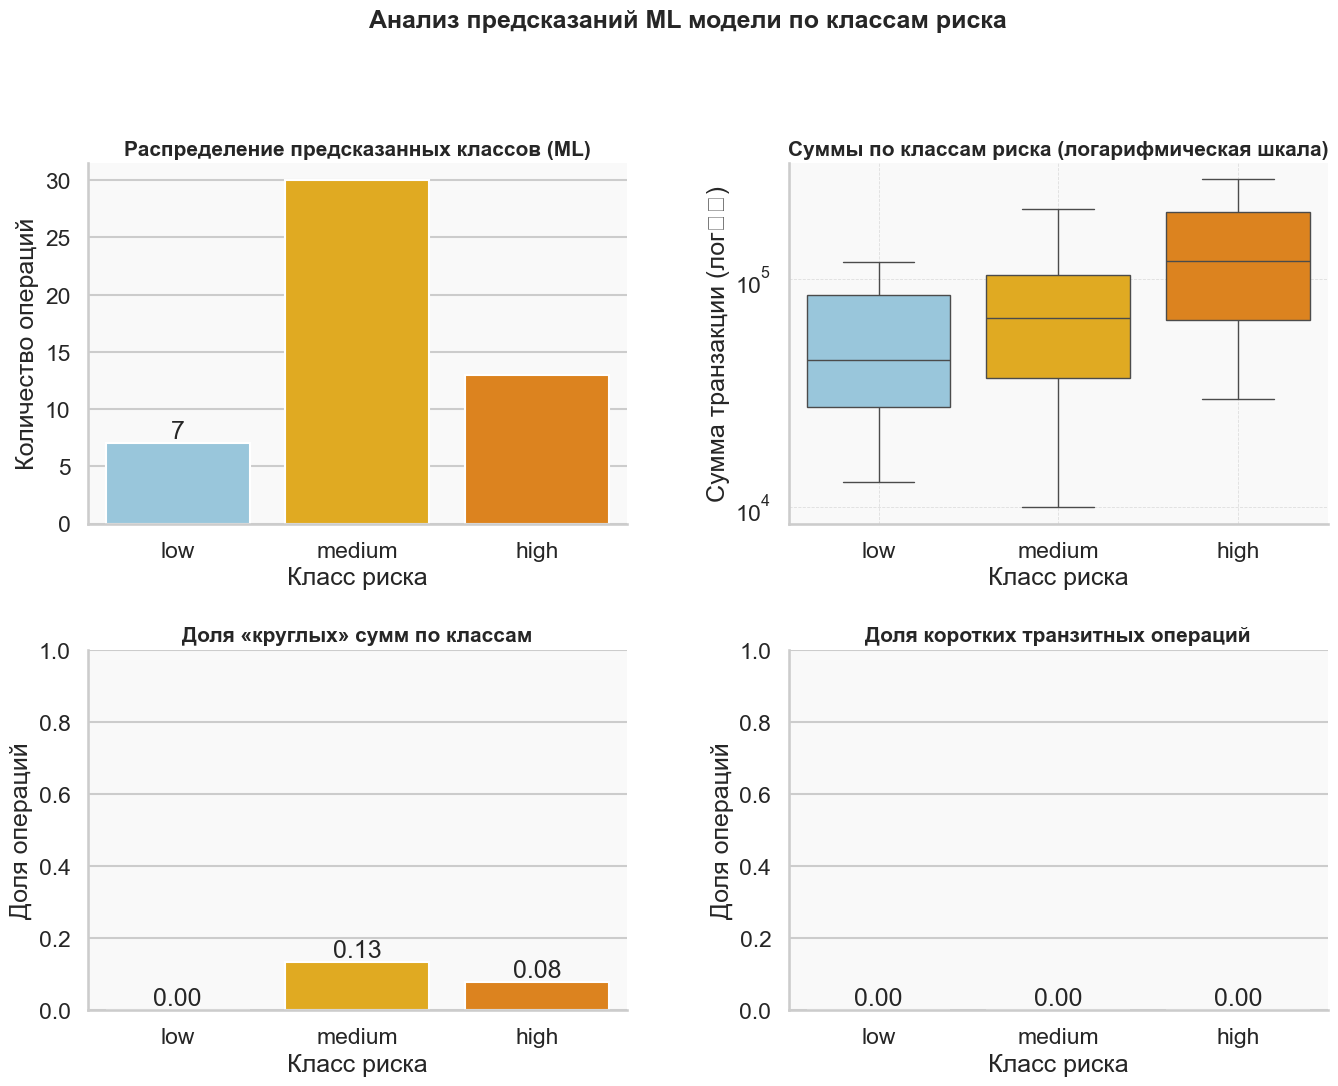

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt

dfp = STATE["df_prep"].copy()

# --- Общий стиль ---
sns.set_theme(style="whitegrid", context="talk", palette="Set2")

fig, axes = plt.subplots(2, 2, figsize=(16, 11))
plt.subplots_adjust(hspace=0.35, wspace=0.3)

# --- 1. Распределение классов ---
sns.countplot(
    data=dfp, 
    x="ml_pred_class", 
    order=["low","medium","high"], 
    palette=["#8ecae6","#ffb703","#fb8500"], 
    ax=axes[0,0]
)
axes[0,0].set_title("Распределение предсказанных классов (ML)", fontsize=15, weight="bold")
axes[0,0].set_xlabel("Класс риска")
axes[0,0].set_ylabel("Количество операций")
axes[0,0].bar_label(axes[0,0].containers[0])
axes[0,0].set_facecolor("#f9f9f9")

# --- 2. Суммы по классам (лог) ---
sns.boxplot(
    data=dfp, 
    x="ml_pred_class", 
    y="amount", 
    order=["low","medium","high"],
    palette=["#8ecae6","#ffb703","#fb8500"],
    showfliers=False,  # убираем выбросы для чистоты
    ax=axes[0,1]
)
axes[0,1].set_yscale("log")
axes[0,1].set_title("Суммы по классам риска (логарифмическая шкала)", fontsize=15, weight="bold")
axes[0,1].set_xlabel("Класс риска")
axes[0,1].set_ylabel("Сумма транзакции (лог₁₀)")
axes[0,1].grid(True, which="major", ls="--", lw=0.6, alpha=0.6)
axes[0,1].set_facecolor("#f9f9f9")

# --- 3. Доля «круглых» сумм ---
round_share = (
    dfp.groupby("ml_pred_class")["round_amount"]
    .mean()
    .reindex(["low","medium","high"])
    .reset_index()
)
sns.barplot(
    data=round_share, 
    x="ml_pred_class", 
    y="round_amount",
    palette=["#8ecae6","#ffb703","#fb8500"], 
    ax=axes[1,0]
)
axes[1,0].set_ylim(0,1)
axes[1,0].set_title("Доля «круглых» сумм по классам", fontsize=15, weight="bold")
axes[1,0].set_xlabel("Класс риска")
axes[1,0].set_ylabel("Доля операций")
for container in axes[1,0].containers:
    axes[1,0].bar_label(container, fmt="%.2f")
axes[1,0].set_facecolor("#f9f9f9")

# --- 4. Доля коротких транзитов ---
transit_share = (
    dfp.groupby("ml_pred_class")["transit_short"]
    .mean()
    .reindex(["low","medium","high"])
    .reset_index()
)
sns.barplot(
    data=transit_share, 
    x="ml_pred_class", 
    y="transit_short",
    palette=["#8ecae6","#ffb703","#fb8500"], 
    ax=axes[1,1]
)
axes[1,1].set_ylim(0,1)
axes[1,1].set_title("Доля коротких транзитных операций", fontsize=15, weight="bold")
axes[1,1].set_xlabel("Класс риска")
axes[1,1].set_ylabel("Доля операций")
for container in axes[1,1].containers:
    axes[1,1].bar_label(container, fmt="%.2f")
axes[1,1].set_facecolor("#f9f9f9")

# --- Общий заголовок ---
plt.suptitle("Анализ предсказаний ML модели по классам риска", fontsize=18, weight="bold", y=1.02)

sns.despine()
plt.show()



In [186]:
# 3) Получить ровно тот массив, который пойдёт в LLM внутри llm_assess_risk()
payload_dict = STATE.get("llm_payload") or {"INPUT_DATA": STATE["input_data"]}
rows_for_llm = payload_dict["INPUT_DATA"]  # <- именно это уходит в LLM

print("Записей в отправляемом батче:", len(rows_for_llm))
rows_for_llm[:5]

Записей в отправляемом батче: 10


[{'id': 884,
  'purpose': 'экспорт по договору №5081',
  'ml_metric': 0.014820821738406653,
  'anomaly_amount': 0.14142135623589988,
  'anomaly_frequency': 0.03333333333333333,
  'anomaly_purpose': 1.0,
  'anomaly_overall': 1.0,
  'is_regular_payment': False,
  'debit_name_type': 'ЮЛ',
  'credit_name_type': 'ИП',
  'debit_amount': None,
  'credit_amount': 204377.98,
  'amount': 204377.98,
  'debit_inn': '4037613794',
  'credit_inn': '672324876357',
  'chain_match': None,
  'chain_length': None,
  'chain_duration_hours': None,
  'ml_top_reasons': []},
 {'id': 900,
  'purpose': 'частичная оплата согласно счёту №74969',
  'ml_metric': 1.2785413485174223e-06,
  'anomaly_amount': 0.14142135623315608,
  'anomaly_frequency': 0.06666666666666667,
  'anomaly_purpose': 0.0,
  'anomaly_overall': 0.14142135623315608,
  'is_regular_payment': False,
  'debit_name_type': 'ЮЛ',
  'credit_name_type': 'ЮЛ',
  'debit_amount': 84471.44,
  'credit_amount': None,
  'amount': 84471.44,
  'debit_inn': '749894